### Data Exploration

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine # Engine required to read the SQL from PGAdmin4
from config import CONNSTRING

In [141]:
# Create a database engine
engine = create_engine(CONNSTRING)

# Define your SQL query
query = "SELECT * FROM PatientData"

# Use pandas to read the data into a DataFrame
liver_data_df = pd.read_sql(query, engine)
liver_data_df.head()

,age,gender,bmi,alcoholconsumption,smoking,geneticrisk,physicalactivity,diabetes,hypertension,liverfunctiontest,diagnosis
0,58,0,35.857584,17.272828,0,1,0.658940,0,0,42.734240,1
1,71,1,30.732470,2.201266,0,1,1.670557,1,0,67.309822,1
2,48,0,19.971407,18.500944,0,0,9.928308,0,0,63.738956,0
3,34,1,16.615417,12.632870,0,0,5.630129,0,0,64.555873,1
4,62,1,16.065830,1.087815,0,1,3.566218,1,0,77.868689,1


## Exploratory Data Analysis

In [142]:
liver_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 1700 non-null   int64  
 1   gender              1700 non-null   int64  
 2   bmi                 1700 non-null   float64
 3   alcoholconsumption  1700 non-null   float64
 4   smoking             1700 non-null   int64  
 5   geneticrisk         1700 non-null   int64  
 6   physicalactivity    1700 non-null   float64
 7   diabetes            1700 non-null   int64  
 8   hypertension        1700 non-null   int64  
 9   liverfunctiontest   1700 non-null   float64
 10  diagnosis           1700 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 146.2 KB


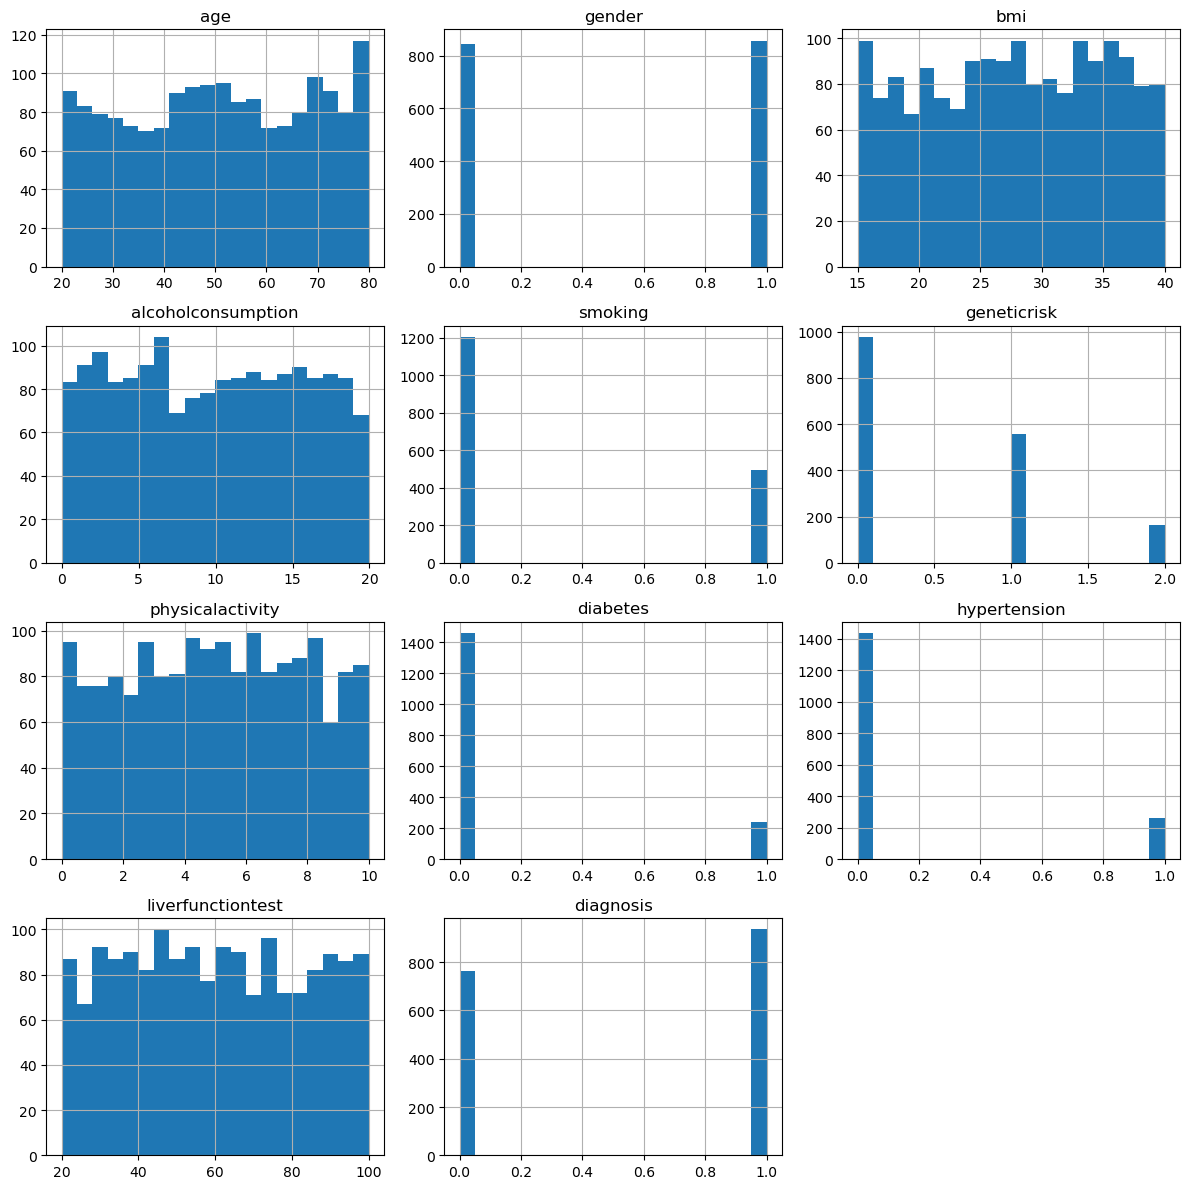

In [143]:
# Plot histograms for each feature
liver_data_df.hist(figsize=(12, 12), bins=20)
plt.tight_layout()
plt.show()

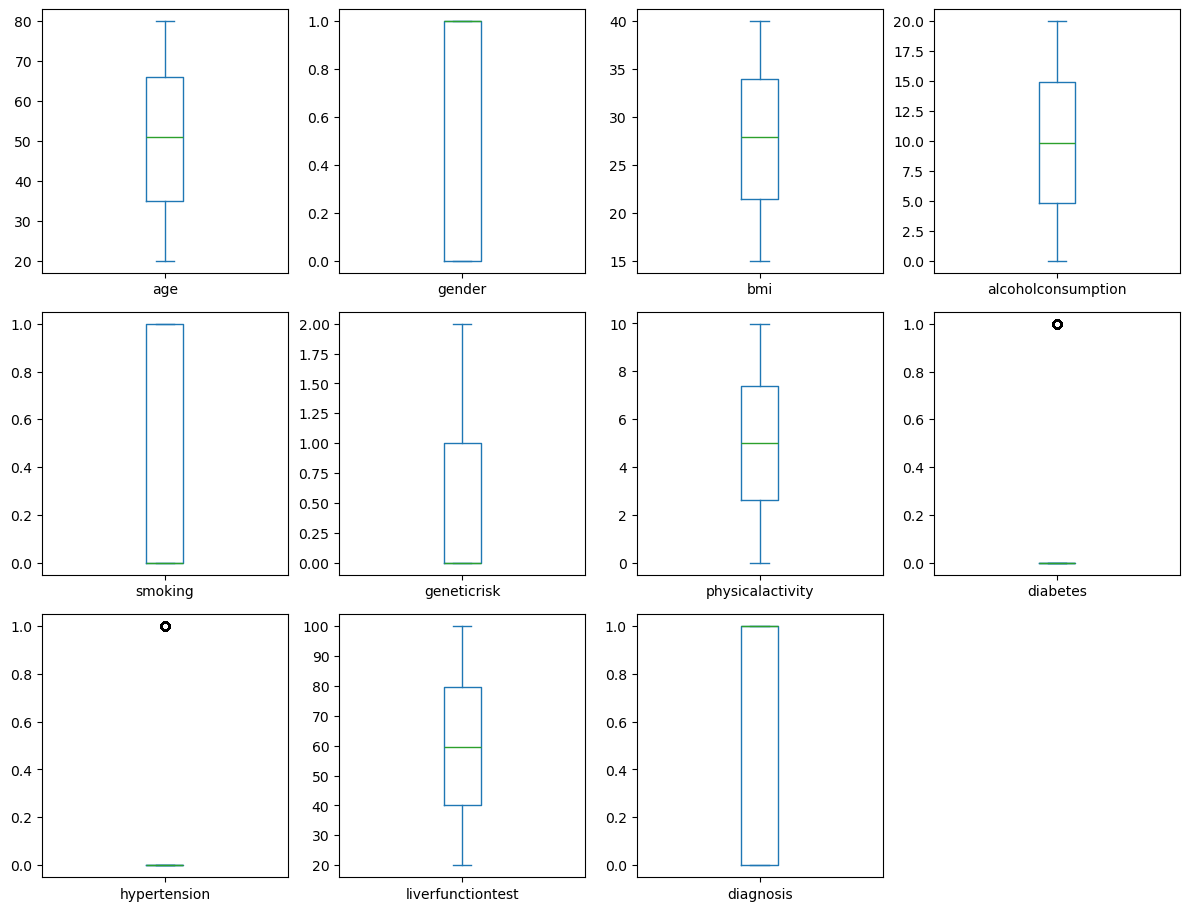

In [144]:
# Plot boxplots for each feature
liver_data_df.plot(kind='box', subplots=True, layout=(4, 4), figsize=(12, 12), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

                         age    gender       bmi  alcoholconsumption  \
age                 1.000000 -0.009323  0.038283            0.008236   
gender             -0.009323  1.000000  0.013458           -0.003312   
bmi                 0.038283  0.013458  1.000000           -0.024749   
alcoholconsumption  0.008236 -0.003312 -0.024749            1.000000   
smoking            -0.013683 -0.023403 -0.018322           -0.013794   
geneticrisk        -0.012948  0.017394 -0.007686           -0.016808   
physicalactivity   -0.015212  0.009379 -0.010888           -0.024232   
diabetes            0.024209  0.000012 -0.007808            0.013490   
hypertension        0.000678  0.024131 -0.004850            0.016640   
liverfunctiontest  -0.013105  0.024603  0.043684           -0.043480   
diagnosis           0.156099  0.189558  0.167655            0.349610   

                     smoking  geneticrisk  physicalactivity  diabetes  \
age                -0.013683    -0.012948         -0.015212  0

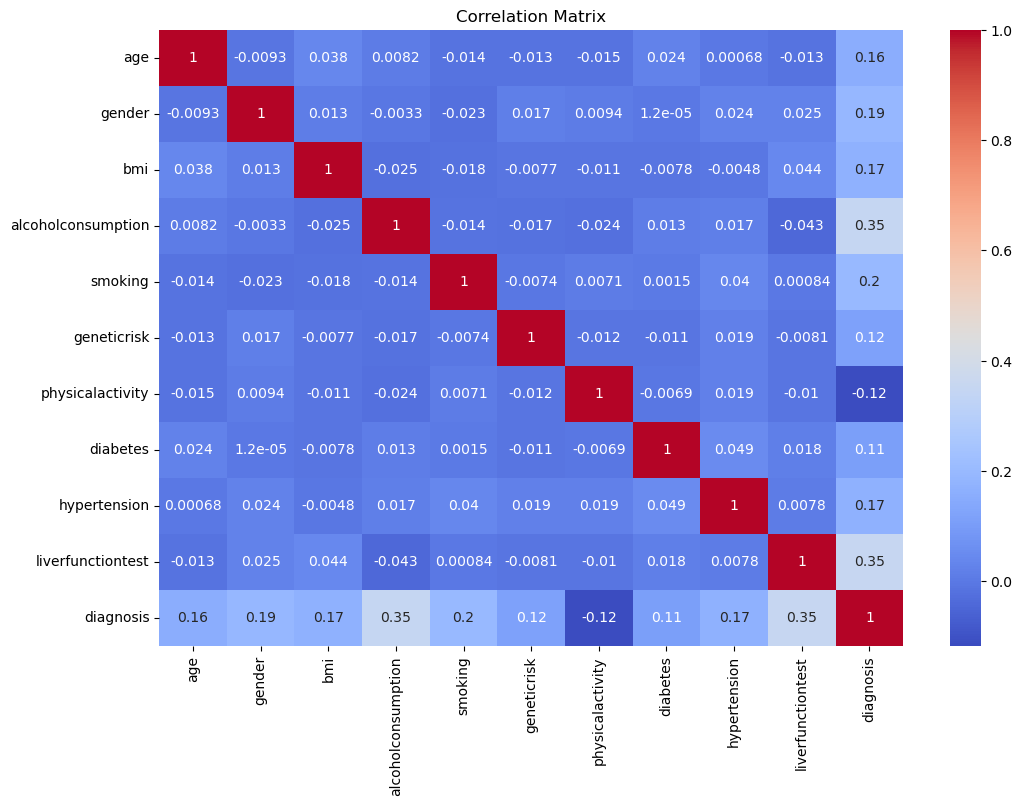

In [145]:
# Calculate the correlation matrix
correlation_matrix = liver_data_df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Generally, the interpretation of correlation coefficients is as follows:

### 0.0 to 0.3 (or 0.0 to -0.3): Weak correlation
### 0.3 to 0.7 (or -0.3 to -0.7): Moderate correlation
### 0.7 to 1.0 (or -0.7 to -1.0): Strong correlation

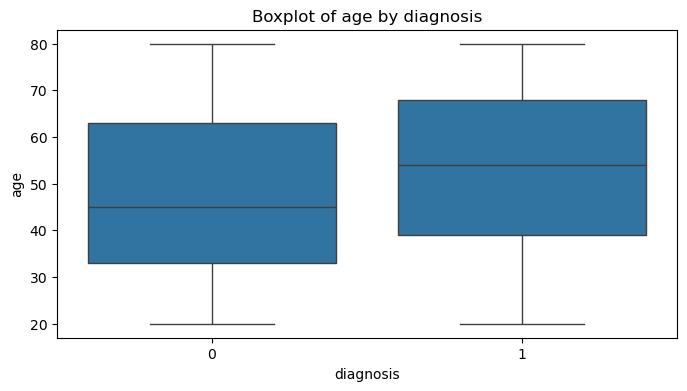

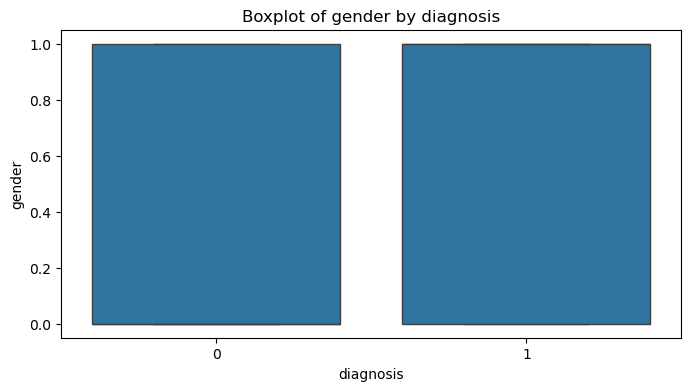

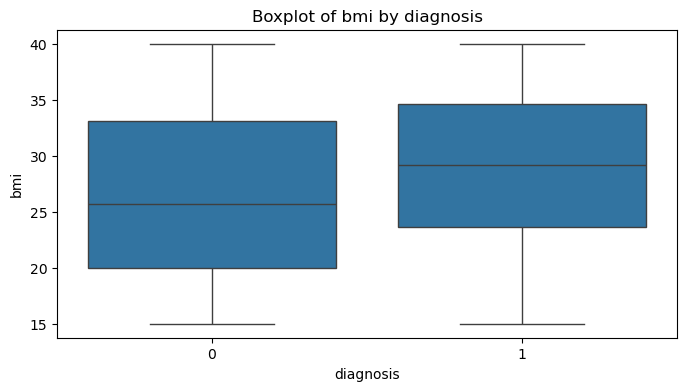

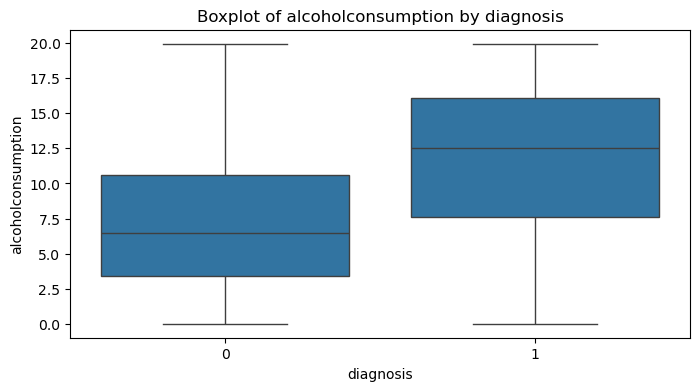

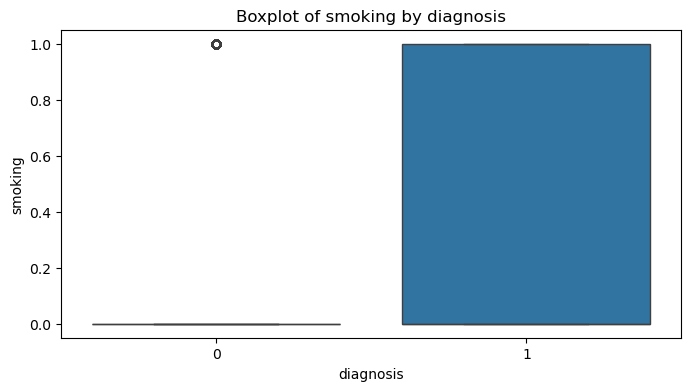

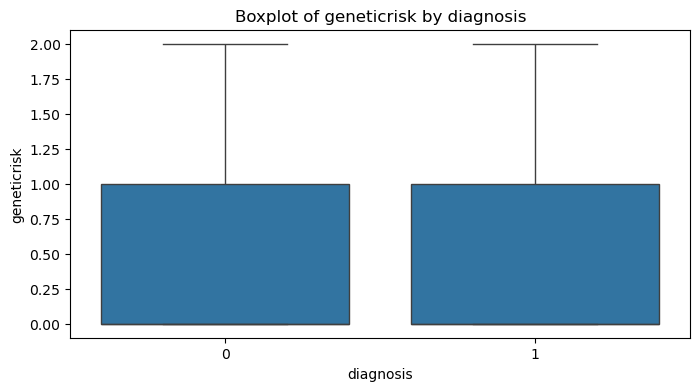

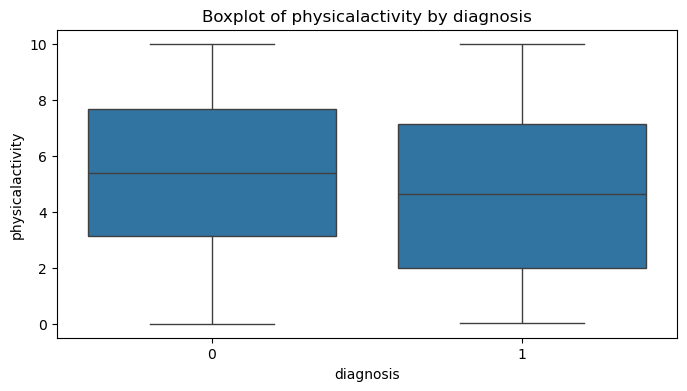

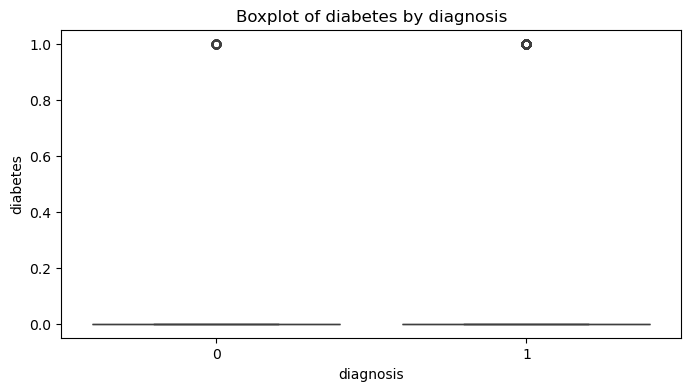

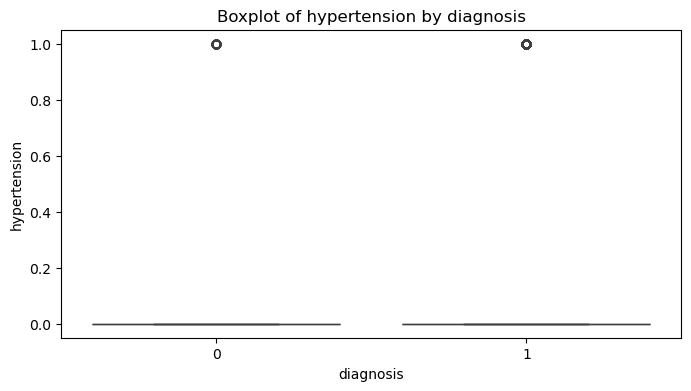

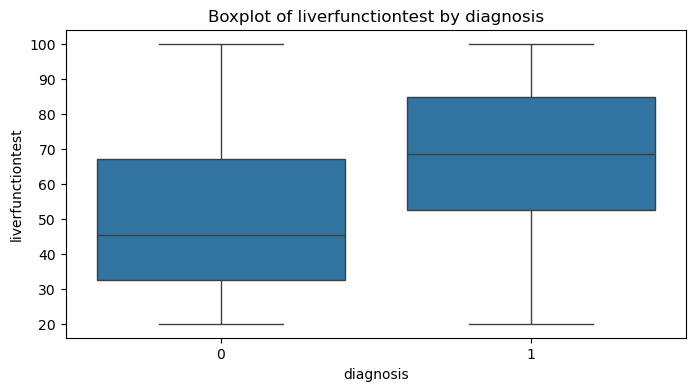

In [146]:
# Plot boxplots for each feature against the target variable
for column in liver_data_df.columns:
    if column != 'diagnosis':  # Replace 'Target' with your binary classification target column name
        plt.figure(figsize=(8, 4))
        sns.boxplot(x='diagnosis', y=column, data=liver_data_df)  # Replace 'Target' with your binary classification target column name
        plt.title(f'Boxplot of {column} by diagnosis')
        plt.show()

# Now let's find a suitable Machine Learning model to try to predict Liver Disease based on the available variables
##### (Run each model separately on the respective jupyter notebooks)